In [1]:
import sys
import os
import torch
import torch.nn.utils.prune as prune
from transformers import DistilBertTokenizerFast
from datasets import load_dataset
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from nn_model_train import DistilBERTFineTuner  # Import your model class


In [2]:
# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Load and preprocess the ag_news dataset
dataset = load_dataset("ag_news")
test_data = dataset["test"].map(lambda batch: tokenizer(batch['text'], padding='max_length', truncation=True, max_length=64), batched=True)
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataloader = DataLoader(test_data, batch_size=32)

In [3]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define pruning percentages
pruning_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # 0%, 10%, 20%, 30%

In [4]:
# Function to evaluate model accuracy
def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            # Forward pass through the model
            outputs = model.model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    # Calculate accuracy
    all_preds_tensor = torch.tensor(all_preds)
    all_labels_tensor = torch.tensor(all_labels)
    return accuracy(all_preds_tensor, all_labels_tensor, task="multiclass", num_classes=4)

# List to store accuracies for each pruning percentage
accuracies = []

In [5]:
for amount in pruning_percentages:
    # Reload the model from the checkpoint for each pruning level to start fresh
    checkpoint_path = "checkpoints/best-checkpoint.ckpt"  # Path to your saved checkpoint
    model = DistilBERTFineTuner.load_from_checkpoint(checkpoint_path)
    model.to(device)  # Move model to the appropriate device
    model.model.to(device)

    # Apply pruning if amount > 0 (skip pruning for 0% level)
    if amount > 0:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)

    # Evaluate and store accuracy
    test_accuracy = evaluate_model(model, test_dataloader)
    accuracies.append(test_accuracy.item())
    print(f"Test Accuracy after Pruning {amount*100:.0f}% of weights: {test_accuracy:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy after Pruning 0% of weights: 0.4839


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy after Pruning 10% of weights: 0.4732


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy after Pruning 20% of weights: 0.4728


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy after Pruning 30% of weights: 0.4716


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy after Pruning 40% of weights: 0.4696


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy after Pruning 50% of weights: 0.4457


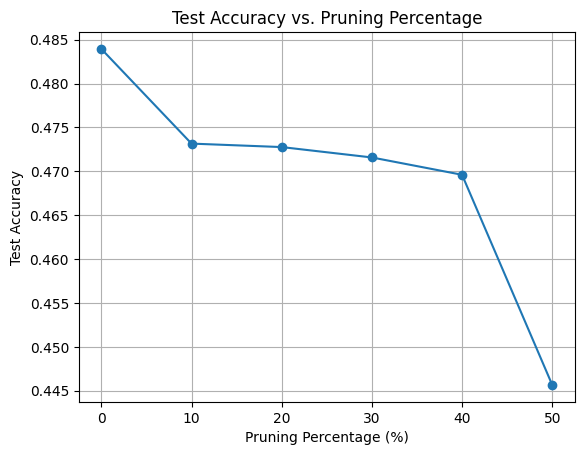

In [6]:
# Plot accuracy vs. pruning percentage
plt.plot([p * 100 for p in pruning_percentages], accuracies, marker='o')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Pruning Percentage')
plt.grid(True)
plt.show()